In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import os
import cv2
import numpy as np
import torch
from PIL import Image
from pytorch_lightning import seed_everything
from tqdm import tqdm

from cldm.model import create_model, load_state_dict
from dataset import PhotoSketchDataset
from inference import run_sampler
from share import *

logging improved.


In [3]:
dataset = PhotoSketchDataset(split="test", data_dir="./data/sketch")

In [4]:
example = dataset[0]
prompt = example["txt"]
sketch = cv2.imread(dataset.sketches[0])
# sketch = dataset.sketches[0]

a pair of shoes sitting on top of a sandy beach


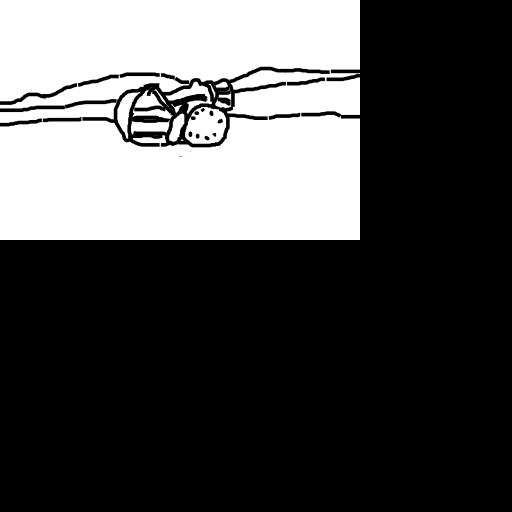

In [5]:
print(prompt)
Image.fromarray(cv2.cvtColor(sketch, cv2.COLOR_BGR2RGB), "RGB")

In [6]:
model = create_model('../models/cldm_v15.yaml').cpu()

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [../models/cldm_v15.yaml]


In [7]:
model.load_state_dict(load_state_dict("/raid/lingo/alexisro/ControlNet/project/experiments/sketch_0503/lightning_logs/version_9/checkpoints/epoch=28-step=57999.ckpt", location='cuda'))
model = model.cuda()

Loaded state_dict from [/raid/lingo/alexisro/ControlNet/project/experiments/sketch_0503/lightning_logs/version_9/checkpoints/epoch=28-step=57999.ckpt]


KeyboardInterrupt: 

In [ ]:
results = run_sampler(model, sketch, prompt, seed=42)

In [ ]:
Image.fromarray(results[0], "RGB")

# Running inference on the whole test set

In [ ]:
RESOLUTION = 512
OUTPUT_DIR = f"photosketch_test_outputs_{RESOLUTION}/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for i in tqdm(range(len(dataset))):
    example = dataset[i]
    prompt = example["txt"]
    sketch = cv2.imread(dataset.sketches[i])
    results = run_sampler(model, sketch, prompt, image_resolution=RESOLUTION, seed=42, show_progress=False)
    
    image = Image.fromarray(results[0], "RGB")
    image.save(os.path.join(OUTPUT_DIR, f"image_{i:03d}.jpg"))

## Run inference for saved checkpoints for all hyperparams

In [ ]:
import fnmatch
import os

experiments = [
    'lr=1e-05_bs=2',
    'lr=1e-05_bs=4',
    'lr=5e-05_bs=2',
    'lr=5e-05_bs=4',
    'lr=5e-06_bs=2',
    'lr=5e-06_bs=4',
]

def load_model(model_path):
    print("Loading pretrained model...")
    model = create_model('../models/cldm_v15.yaml').cpu()
    print("Loading model weights from: ", model_path)
    model.load_state_dict(load_state_dict(model_path, location='cuda'))
    model = model.cuda()
    print("Done.")
    return model

def run_generate(model, dataset, out_dir, resolution=512):
    os.makedirs(out_dir, exist_ok=True)
    
    print("Writing generations to: ", out_dir)

    for i in tqdm(range(len(dataset))):
        example = dataset[i]
        prompt = example["txt"]
        sketch = cv2.imread(dataset.sketches[i])
        results = run_sampler(model, sketch, prompt, image_resolution=resolution, seed=42, show_progress=False)

        image = Image.fromarray(results[0], "RGB")
        image.save(os.path.join(out_dir, f"image_{i:03d}.jpg"))

def run_inference(exp, 
                  exp_dir='/raid/lingo/alexisro/ControlNet/project/experiments',
                  gen_dir='/raid/lingo/alexisro/ControlNet/project/generations'):
    """ 
    exp_dir: points to where experiment subdirectories are 
    gen_dir: where to output generations
    """
    
    sub_exp_dir = os.path.join(exp_dir, exp)
    model_paths = []
    
    
    # TODO: what if there are multiple versions?
    for dirpath, dirnames, filenames in os.walk(sub_exp_dir):
        for filename in fnmatch.filter(filenames, '*.ckpt'):
            full_path = os.path.join(dirpath, filename)
            version = dirpath.split("/")[-2]
            model_paths.append((full_path, version, filename))

    for model_path, version, stub in model_paths:
        out_dir = os.path.join(gen_dir, exp)
        os.makedirs(out_dir, exist_ok=True)
        log_txt_path = os.path.join(out_dir, 'model_path.txt')
        print("Writing log txt to:", log_txt_path)
        model = load_model(model_path)
        with open(log_txt_path, 'w') as f:
            print(model_path, file=f)
        run_generate(model, dataset, out_dir)
    
for exp_idx, exp in enumerate(experiments):
    print("\n====================================================================================")
    print(f"Running inference for experiment {exp_idx+1}/{len(experiments)}:", exp)
    run_inference(exp)
    


Running inference for experiment 1/6: lr=1e-05_bs=2
Writing log txt to: /raid/lingo/alexisro/ControlNet/project/generations/lr=1e-05_bs=2/model_path.txt
Loading pretrained model...
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [../models/cldm_v15.yaml]
Loading model weights from:  /raid/lingo/alexisro/ControlNet/project/experiments/lr=1e-05_bs=2/lightning_logs/version_0/checkpoints/epoch=5-step=4001.ckpt
Loaded state_dict from [/raid/lingo/alexisro/ControlNet/project/experiments/lr=1e-05_bs=2/lightning_logs/version_0/checkpoints/epoch=5-step=4001.ckpt]
Done.
Writing generations to:  /raid/lingo/alexisro/ControlNet/project/generations/lr=1e-05_bs=2


  0%|                                                                        | 0/500 [00:00<?, ?it/s]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  0%|▏                                                               | 1/500 [00:05<42:52,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  0%|▎                                                               | 2/500 [00:10<42:32,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  1%|▍                                                               | 3/500 [00:15<42:32,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  1%|▌                                                               | 4/500 [00:20<42:16,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  1%|▋                                                               | 5/500 [00:25<42:22,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  1%|▊                                                               | 6/500 [00:30<42:28,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  1%|▉                                                               | 7/500 [00:36<42:24,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  2%|█                                                               | 8/500 [00:41<42:11,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  2%|█▏                                                              | 9/500 [00:46<42:00,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  2%|█▎                                                             | 10/500 [00:51<41:47,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  2%|█▍                                                             | 11/500 [00:56<41:43,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  2%|█▌                                                             | 12/500 [01:01<41:33,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  3%|█▋                                                             | 13/500 [01:06<41:30,  5.11s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  3%|█▊                                                             | 14/500 [01:11<41:31,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  3%|█▉                                                             | 15/500 [01:16<41:23,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  3%|██                                                             | 16/500 [01:22<41:25,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  3%|██▏                                                            | 17/500 [01:27<41:11,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  4%|██▎                                                            | 18/500 [01:32<41:07,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  4%|██▍                                                            | 19/500 [01:37<41:10,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  4%|██▌                                                            | 20/500 [01:42<41:08,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  4%|██▋                                                            | 21/500 [01:47<41:10,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  4%|██▊                                                            | 22/500 [01:52<41:00,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  5%|██▉                                                            | 23/500 [01:58<41:16,  5.19s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  5%|███                                                            | 24/500 [02:03<41:00,  5.17s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  5%|███▏                                                           | 25/500 [02:08<40:43,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  5%|███▎                                                           | 26/500 [02:13<41:01,  5.19s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  5%|███▍                                                           | 27/500 [02:18<40:44,  5.17s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  6%|███▌                                                           | 28/500 [02:23<40:30,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  6%|███▋                                                           | 29/500 [02:29<40:16,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  6%|███▊                                                           | 30/500 [02:34<40:07,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  6%|███▉                                                           | 31/500 [02:39<40:06,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  6%|████                                                           | 32/500 [02:44<39:54,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  7%|████▏                                                          | 33/500 [02:49<39:48,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  7%|████▎                                                          | 34/500 [02:54<39:46,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  7%|████▍                                                          | 35/500 [02:59<39:59,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  7%|████▌                                                          | 36/500 [03:04<39:45,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  7%|████▋                                                          | 37/500 [03:10<39:33,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  8%|████▊                                                          | 38/500 [03:15<39:32,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  8%|████▉                                                          | 39/500 [03:20<39:25,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  8%|█████                                                          | 40/500 [03:25<39:25,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  8%|█████▏                                                         | 41/500 [03:30<39:40,  5.19s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  8%|█████▎                                                         | 42/500 [03:36<39:39,  5.19s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  9%|█████▍                                                         | 43/500 [03:41<39:32,  5.19s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  9%|█████▌                                                         | 44/500 [03:46<39:30,  5.20s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  9%|█████▋                                                         | 45/500 [03:51<40:02,  5.28s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  9%|█████▊                                                         | 46/500 [03:57<39:41,  5.24s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


  9%|█████▉                                                         | 47/500 [04:02<39:12,  5.19s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 10%|██████                                                         | 48/500 [04:07<39:04,  5.19s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 10%|██████▏                                                        | 49/500 [04:12<39:01,  5.19s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 10%|██████▎                                                        | 50/500 [04:17<38:49,  5.18s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 10%|██████▍                                                        | 51/500 [04:22<38:35,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 10%|██████▌                                                        | 52/500 [04:27<38:30,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 11%|██████▋                                                        | 53/500 [04:33<38:23,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 11%|██████▊                                                        | 54/500 [04:38<38:12,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 11%|██████▉                                                        | 55/500 [04:43<38:06,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 11%|███████                                                        | 56/500 [04:48<38:01,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 11%|███████▏                                                       | 57/500 [04:53<37:49,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 12%|███████▎                                                       | 58/500 [04:58<37:50,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 12%|███████▍                                                       | 59/500 [05:03<37:47,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 12%|███████▌                                                       | 60/500 [05:08<37:34,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 12%|███████▋                                                       | 61/500 [05:14<37:30,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 12%|███████▊                                                       | 62/500 [05:19<37:32,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 13%|███████▉                                                       | 63/500 [05:24<37:21,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 13%|████████                                                       | 64/500 [05:29<37:12,  5.12s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 13%|████████▏                                                      | 65/500 [05:34<37:19,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 13%|████████▎                                                      | 66/500 [05:39<37:12,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 13%|████████▍                                                      | 67/500 [05:44<37:13,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 14%|████████▌                                                      | 68/500 [05:50<37:11,  5.17s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 14%|████████▋                                                      | 69/500 [05:55<37:03,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 14%|████████▊                                                      | 70/500 [06:00<36:57,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 14%|████████▉                                                      | 71/500 [06:05<36:59,  5.17s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 14%|█████████                                                      | 72/500 [06:10<36:48,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 15%|█████████▏                                                     | 73/500 [06:15<36:38,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 15%|█████████▎                                                     | 74/500 [06:21<36:31,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 15%|█████████▍                                                     | 75/500 [06:26<36:22,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 15%|█████████▌                                                     | 76/500 [06:31<36:24,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 15%|█████████▋                                                     | 77/500 [06:36<36:18,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 16%|█████████▊                                                     | 78/500 [06:41<36:12,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 16%|█████████▉                                                     | 79/500 [06:46<36:02,  5.14s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 16%|██████████                                                     | 80/500 [06:51<35:54,  5.13s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 16%|██████████▏                                                    | 81/500 [06:57<35:59,  5.15s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 16%|██████████▎                                                    | 82/500 [07:02<35:58,  5.17s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


 17%|██████████▍                                                    | 83/500 [07:07<35:52,  5.16s/it]Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps
